In [14]:
!python -m pip install pennylane pennylane-lightning pennylane-lightning-gpu --upgrade


In [15]:
!pip install custatevec-cu12


In [16]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
import time
import tensorflow as tf
print("Available devices:")
print(tf.config.list_physical_devices('GPU'))

# Load the MNIST dataset
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and flatten the MNIST data
x_train_flat = x_train.reshape(len(x_train), -1) / 255.0
x_test_flat = x_test.reshape(len(x_test), -1) / 255.0

# Reduce dimensionality using PCA
pca = PCA(n_components=10)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_pca)
x_test_scaled = scaler.transform(x_test_pca)

# Subset for faster computation
x_train_subset, y_train_subset = x_train_scaled[:200], y_train[:200]
x_test_subset, y_test_subset = x_test_scaled[:50], y_test[:50]

# Convert labels to binary classification (digit 0 vs not 0)
y_train_subset = np.array([1 if y == 0 else 0 for y in y_train_subset])
y_test_subset = np.array([1 if y == 0 else 0 for y in y_test_subset])

# Quantum device setup using TensorFlow backend
n_qubits = 10  # Match PCA output dimensions
dev = qml.device("lightning.gpu", wires=n_qubits)

# Define a variational quantum circuit for kernel computation
@qml.qnode(dev, interface="tf")
def quantum_circuit(x1, x2):
    # Encode the first data point
    for i in range(n_qubits):
        qml.RX(x1[i], wires=i)
        qml.RY(x1[i], wires=i)
        qml.RZ(x1[i], wires=i)

    # Apply entanglement
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # Encode the second data point
    for i in range(n_qubits):
        qml.RX(x2[i], wires=i)
        qml.RY(x2[i], wires=i)
        qml.RZ(x2[i], wires=i)

    # Measure the overlap between states
    return qml.expval(qml.PauliZ(0))

def quantum_kernel(x1, x2):
    """Compute the quantum kernel using the defined quantum circuit."""
    return quantum_circuit(x1, x2)

# Compute the kernel matrix
def compute_kernel_matrix(data1, data2):
    """Compute the kernel matrix using the quantum kernel."""
    kernel_matrix = np.zeros((len(data1), len(data2)))
    for i in range(len(data1)):
        for j in range(len(data2)):
            kernel_matrix[i, j] = quantum_kernel(data1[i], data2[j])
    return kernel_matrix

# Train the quantum-enhanced SVM
print("Training the quantum-enhanced SVM...")
start_time = time.time()

# Compute the quantum kernel matrices
quantum_train_kernel = compute_kernel_matrix(x_train_subset, x_train_subset)
quantum_test_kernel = compute_kernel_matrix(x_test_subset, x_train_subset)

# Train the SVM
qsvm = SVC(kernel="precomputed")
qsvm.fit(quantum_train_kernel, y_train_subset)

# Predict and evaluate
y_pred = qsvm.predict(quantum_test_kernel)
accuracy = accuracy_score(y_test_subset, y_pred)
end_time = time.time()

# Results
print("\n--- Results ---")
print(f"Quantum SVM Accuracy: {accuracy:.4f}")
print(f"Total Computation Time: {end_time - start_time:.2f} seconds")

time_quantum = end_time - start_time


Available devices:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading MNIST dataset...
Training the quantum-enhanced SVM...

--- Results ---
Quantum SVM Accuracy: 0.9000
Total Computation Time: 299.97 seconds


In [17]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
# Train a classical SVM for comparison
print("Training the classical SVM...")
start_time = time.time()

# Load the MNIST dataset
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and flatten the MNIST data
x_train_flat = x_train.reshape(len(x_train), -1) / 255.0
x_test_flat = x_test.reshape(len(x_test), -1) / 255.0

# Reduce dimensionality using PCA
pca = PCA(n_components=10)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_pca)
x_test_scaled = scaler.transform(x_test_pca)

# Subset for faster computation
x_train_subset, y_train_subset = x_train_scaled[:200], y_train[:200]
x_test_subset, y_test_subset = x_test_scaled[:50], y_test[:50]


classical_svm = SVC(kernel="linear")
classical_svm.fit(x_train_subset, y_train_subset)

# Predict and evaluate
y_pred_classical = classical_svm.predict(x_test_subset)
accuracy_classical = accuracy_score(y_test_subset, y_pred_classical)
end_time_Classical = time.time()

# Results
print("\n--- Classical Results ---")
print(f"Classical SVM Accuracy: {accuracy_classical:.4f}")
print(f"Total Computation Time: {end_time_Classical - start_time:.2f} seconds")

time_classical = end_time_Classical - start_time

Training the classical SVM...
Loading MNIST dataset...

--- Classical Results ---
Classical SVM Accuracy: 0.7400
Total Computation Time: 0.89 seconds


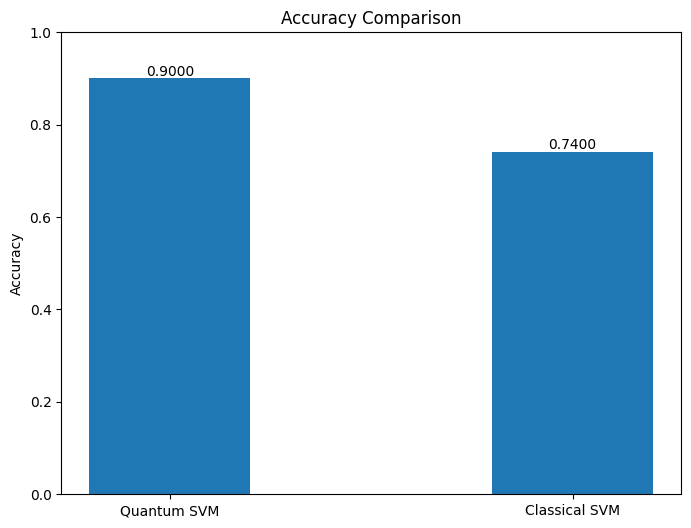

In [18]:
import matplotlib.pyplot as plt
# Visualize a subset of predictions
# Visualization of accuracy comparison
accuracies = [accuracy, accuracy_classical]
methods = ['Quantum SVM', 'Classical SVM']

plt.figure(figsize=(8, 6))
plt.bar(methods, accuracies, width=0.4)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.text(0, accuracy, f"{accuracy:.4f}", ha='center', va='bottom')
plt.text(1, accuracy_classical, f"{accuracy_classical:.4f}", ha='center', va='bottom')
plt.show()



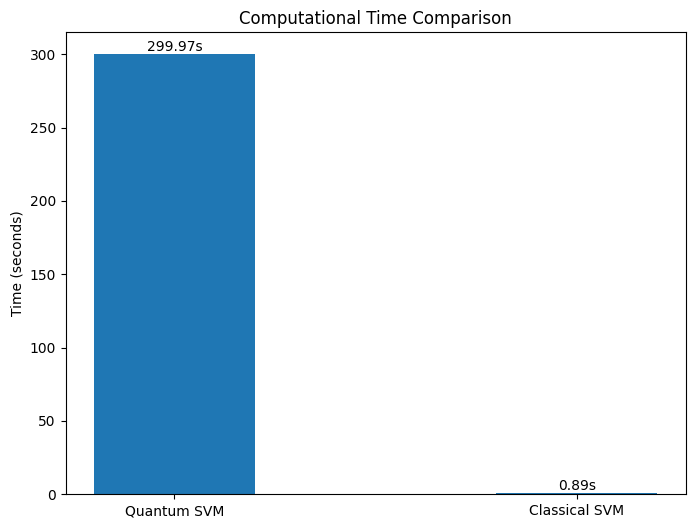

In [22]:
# Visualization of computational time comparison
times = [time_quantum, time_classical]
methods = ['Quantum SVM', 'Classical SVM']

plt.figure(figsize=(8, 6))
plt.bar(methods, times, width=0.4)
plt.ylabel('Time (seconds)')
plt.title('Computational Time Comparison')
plt.text(0, time_quantum, f"{time_quantum:.2f}s", ha='center', va='bottom')
plt.text(1, time_classical, f"{time_classical:.2f}s", ha='center', va='bottom')
plt.show()
